Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import glob
import zipfile
from zipfile import BadZipFile
import datetime
import pandas as pd
import hyp3_sdk as sdk
from hyp3_sdk import asf_search
from tqdm.notebook import trange, tqdm
from hyp3lib import cutGeotiffs
import geopandas as gpd
from pathlib import Path
import shutil
# from tqdm.auto import tqdm

/opt/conda/lib/python3.9/site-packages/hyp3_sdk/asf_search.py:8: FutureWarning: 
hyp3_sdk.asf_search is deprecated and functionality has been superseded by the `asf_search` package available on conda-forge and PyPI. See: https://github.com/asfadmin/Discovery-asf_search
  warnings.warn('\nhyp3_sdk.asf_search is deprecated and functionality has been '


In [2]:
pwd

'/home/micromamba/work/hyp3_insar'

In [3]:
project_name = 'asc_lower'
out_dir = Path('../asc_lower').resolve()

if not out_dir.is_dir():
    out_dir.mkdir()

In [4]:
# gdf = gpd.read_file('desc-lower-2021-10-21.geojson')
asf = Path('asf_files')
gdf = gpd.read_file(asf/'asc-lower-2021-11-04.geojson')
min_date = pd.to_datetime('20140201T000000')
max_date = pd.to_datetime('20211230T000000')

In [5]:
gdf = gdf.loc[:,['fileName','startTime','geometry']]
gdf = gdf.to_crs(epsg=32760)
gdf['startTime'] = pd.to_datetime(gdf.startTime)
gdf = gdf.sort_values('startTime').reset_index(drop=True)
# gdf = gdf.loc[gdf.startTime <= max_date]

In [6]:
template = gdf.loc[gdf.startTime==gdf.startTime.max()]
union = gpd.overlay(gdf, template, how='intersection')
gdf['intersect'] = union.area / template.area.item()

n ifgs: 181


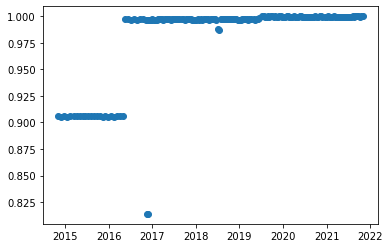

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(gdf.startTime,gdf.intersect)
print(f'n ifgs: {len(gdf)}')

In [8]:
gap = gdf.loc[(gdf.startTime>=pd.to_datetime('20160415')) & (gdf.startTime<=pd.to_datetime('20160530'))].copy()
gap['startTime'] = gap['startTime'].dt.strftime('%y%m%d')
# gap.explore()

Removed 40 of 181 SLCs


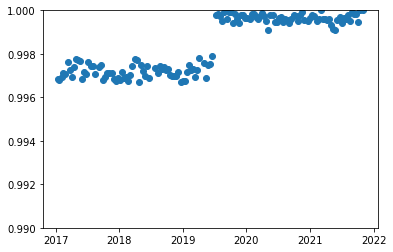

In [9]:
min_date = pd.to_datetime('20170101T000000')
min_overlap = 0.99
slcs = gdf[(gdf.intersect>min_overlap) & (gdf.startTime>=min_date)].copy().reset_index(drop=True)
print(f'Removed {gdf.shape[0] - slcs.shape[0]} of {gdf.shape[0]} SLCs')

plt.scatter(slcs.startTime,slcs.intersect)
y = plt.ylim((min_overlap,1))

In [38]:
pairs = {}
todo = 0
names = slcs.fileName.str[:-4]
length = names.shape[0]

completed = ['_'.join(x.name.split('_')[1:3]) for x in out_dir.glob('*zip')]

for i,reference_name in enumerate(names):
    reference_date = reference_name.split('_')[5]
    secondary = []
    
    for j in [1,2,3]:
        index = i+j
        secondary_name = None
        date12 = None
        
        if index < length:
            secondary_name = names[index]
            secondary_date = secondary_name.split('_')[5]
            date12 = f'{reference_date}_{secondary_date}'
        
        if (secondary_name != None) & (date12 not in completed):
            secondary.append(names[index])
            todo += 1
        elif (secondary_name != None) & (date12 in completed):
            completed.remove(date12)

    if secondary != []:
        pairs[reference_name] = secondary

print(f'{todo} interferograms need to be requested, {len(completed)} are done')

55 interferograms need to be requested, 0 are done


In [ ]:
# bad = [list(out_dir.glob(f'*{x}*')) for x in completed]
# [shutil.move(x,Path(x.parent,'bad_asc_lower',x.name)) for x in bad]

Enter Hyp3 credentials

In [104]:
hyp3 = sdk.HyP3(prompt=True)

my_info = hyp3.my_info()
print(f"Remaining Quota: {my_info['quota']['remaining']}")

Request Ifg generation

In [41]:
insar_jobs = sdk.Batch()
first = False

options = {'name':project_name,'looks':'10x2', 'include_wrapped_phase':False, 'apply_water_mask':True}
initial_options = dict(options)
initial_options.update({'include_inc_map':True,'include_dem':True,'include_look_vectors':True})

In [50]:
m = 0
for key in pairs:
    m = max(m,len(pairs[key]))
m

3

In [42]:
for reference in tqdm(pairs):
    for secondary in pairs[reference]:
        if first:
            insar_jobs += hyp3.submit_insar_job(reference, secondary, **initial_options)
            first = False
        else:
            insar_jobs += hyp3.submit_insar_job(reference, secondary, **options)

  0%|          | 0/23 [00:00<?, ?it/s]

Check progress and download

In [ ]:
start = datetime.datetime.today() - datetime.timedelta(days=3)

batch = hyp3.find_jobs(name=project_name,start=start)

if batch.complete():
    #filter to only succeeded jobs
    succeeded_jobs = batch.filter_jobs(succeeded=True, running=False, failed=False)
    
    complete = 0
    #download files if not downloaded already
    for job in succeeded_jobs.jobs:
        filename = job.to_dict()['files'][0]['filename']
        # location = os.path.join(project_name,filename)
        # if not os.path.exists(location):
        #     job.download_files(location=project_name,create=True)
        location = out_dir / filename
        if not location.exists():
            job.download_files(location=str(out_dir),create=True)
        else:
            complete += 1

    print(f'{complete} files already downloaded!')

else:
    #to get updated information
    batch = hyp3.refresh(batch)
    #or to wait until completion and get updated information (which will take a fair bit)
    batch = hyp3.watch(batch)

Unzip files and clip to same extent

In [103]:
zips = list(out_dir.glob('*.zip'))
unws = [x.with_suffix('') / f'{x.name.split(".")[0]}_unw_phase.tif' for x in zips]

zips = [x for x,y in zip(zips,unws) if not y.exists()]

bad_files=[]

for zip_file in tqdm(zips, total=len(zips)):
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(out_dir)
    except BadZipFile:
        bad_files.append(os.path.basename(zip_file))

if len(bad_files) > 0:
    print(f'These files were invalid zips:\n{bad_files}')
else:
    print('All files were unzipped successfully!')

0it [00:00, ?it/s]

All files were unzipped successfully!


In [101]:
folders = [x for x in out_dir.glob('S1*') if x.is_dir()]
all_images = []

for suffix in ['dem','lv_theta','water_mask','unw_phase','corr']:
    images = [x / f'{x.name}_{suffix}.tif' for x in folders]
    images = [x for x in images if x.exists()]
    
    # We only need the lv_theta and water_mask files found in the dem directory
    if suffix == 'dem':
        prefix = str(images[0]).replace('dem.tif','')
    elif suffix not in ['unw_phase','corr']:
        images = [x for x in images if prefix in str(x)]
    
    all_images += images

to_clip = [str(x) for x in all_images if not Path(str(x).replace('.tif','_clip.tif')).exists()]
print(f'{len(to_clip)} images to clip')

837 images to clip


In [ ]:
cutGeotiffs.cutFiles(to_clip)

Done!